In [203]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import time
import torch
import os
import torch.nn as nn
import torch.optim as optim
import csv
import torchvision
import torchtext
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
import torchtext.vocab as vocab
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchtext import data
import matplotlib.pyplot as plt
from PIL import Image
import torchtext.data
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
import torchtext
import pandas as pd
import torchtext.datasets as datasets


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
data = pd.read_csv('/kaggle/input/dataset/aug_labels.tsv', sep='\t')
#Panda adds a random column to the data so do:
data = data.drop(columns='Unnamed: 0')

print(data.shape) # >>> should be like (22803,1) or smth

#Convert the dataframe to a list

labels = data.values.tolist() #you now have a list of the labels
print("This is the first label: ", labels[0])


images = torch.load('/kaggle/input/dataset/aug_images.pt') 
print(images.shape) #should be the 22803,3,224,224

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/aug_labels.tsv
/kaggle/input/dataset/aug_images.pt
(22804, 1)
This is the first label:  ['a very typical bus station']
torch.Size([22804, 3, 224, 224])


In [68]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


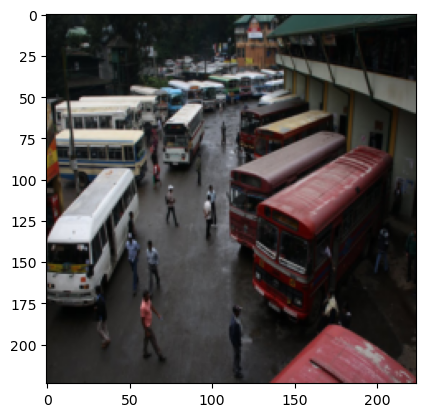

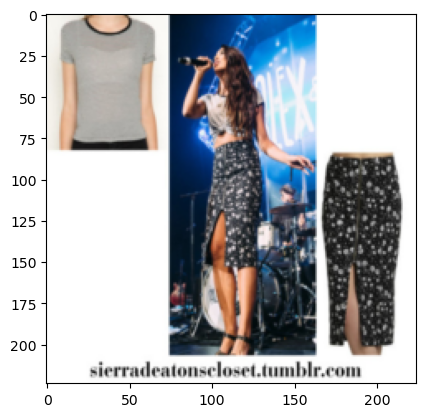

In [99]:
# Just a test to see that the images are being loaded correctly
for i in range (2):
    image = F.to_pil_image(images[i].squeeze(0))
    plt.imshow(image)
    plt.show()

In [247]:
# Create a custom class to create a dataset from an array of tensors
class TensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return x

# Create arrays for each of the datasets
training = []
validation = []
testing = []

# Populate each of the arrays with the images

for i in range(0,5000):
    training.append(images[i])

for n in range(5000, 5350):
    validation.append(images[n])

for m in range(5350, 5701):
    testing.append(images[n])
    
for index in range(5701, 10702):
    training.append(images[index])

for ind in range(11402, 16403):
    training.append(images[ind])

for inde in range(17103, 22104):
    training.append(images[inde])
    
# Adding labels
training_labels = []
validation_labels = []
testing_labels = []

for i in range(0,5000):
    training_labels.append(labels[i])
    print(labels[i])

for n in range(5000, 5350):
    validation_labels.append(labels[n])

for m in range(5350, 5701):
    testing_labels.append(labels[m])
    
for index in range(5701, 10702):
    training_labels.append(labels[index])

for ind in range(11402, 16403):
    training_labels.append(labels[ind])

for inde in range(17103, 22104):
    training_labels.append(labels[inde])

['digital art autumn landscape as oil painting .']


In [258]:
import pandas as pd
import torch
import torchtext.vocab as vocab

# Define the tokenizer (e.g. split on whitespace)
tokenizer = lambda x: x.split()

# Load the data into a pandas dataframe
df = pd.read_csv('/kaggle/input/dataset/aug_labels.tsv', delimiter='\t', header=None, names=['caption'])

# Apply the tokenizer to the 'caption' column
df['caption'] = df['caption'].apply(tokenizer)

# Build the vocabulary
glooooove = vocab.GloVe(name='6B', dim=300)
vocab1 = vocab.vocab(glooooove.stoi)
vocab1.append_token('<pad>')
vocab1.append_token('<start>')
vocab1.append_token('<end>')
vocab1.append_token('<unk>')
word_to_idx = {word: i for i, word in enumerate(vocab1.get_itos())}

# Convert the data to a PyTorch tensor
#captions = torch.tensor([[word_to_idx.get(word, 0) for word in caption] for caption in df['caption']])

words = [word for caption in df['caption'] for word in caption]
print(words[:10])

# Print the resulting tensor and its shape

['caption', 'a', 'very', 'typical', 'bus', 'station', 'sierra', 'looked', 'stunning', 'in']


In [ ]:
label_list = [training_labels, validation_labels, testing_labels]
captions_list = []
for list_type in label_list:
    big_list_words = []
    for label in list_type:
        label = label[0]
        label = label.split()
        list_words = []
        for word in label:
            try:
                list_words.append(vocab1.get_stoi()[word])
            except Exception as e:
                print(e)
                pass
        single_caption_list = [vocab1.get_stoi()['<start>'], list_words.append(vocab1.get_stoi()['<end>'])]
            
        big_list_words.append(single_caption_list)
            
    #captions = torch.as_tensor(big_list_words)

    captions_list.append(big_list_words)
    
training_labels = captions_list[0]

validation_labels = captions_list[1]

test_labels = captions_list[2]

In [250]:
# Create the dataloaders using the custom class
# Create a dataset from the array of tensors
training_data = TensorDataset(training, training_labels)
validation_data = TensorDataset(validation, validation_labels)
testing_data = TensorDataset(testing, testing_labels)

# Create a DataLoader from the dataset
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

<class '__main__.TensorDataset'>


In [80]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [89]:
!pip uninstall torchtext --yes

Found existing installation: torchtext 0.9.0
Uninstalling torchtext-0.9.0:
  Successfully uninstalled torchtext-0.9.0


In [93]:
!pip install torch==1.8.0 torchtext==0.9.0

In [193]:
class CaptionGenerator(nn.Module):
    def __init__(self, embed_size=256, hidden_size=512, vocab_size=400000, num_layers=1):
        super(CaptionGenerator, self).__init__()

        self.name = "CaptionNet"
        # Load a pre-trained CNN
        self.cnn = models.resnet50(pretrained=True)
        # Remove the final fully connected layer
        modules = list(self.cnn.children())[:-1]
        self.cnn = nn.Sequential(*modules)

        # Add a new fully connected layer with the desired output size
        self.cnn = self.cnn.append(nn.Linear(1000, 2048, embed_size))

        # Define an RNN-based captioning model
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Define an embedding layer to convert captions to vectors
        self.embed = nn.Embedding(vocab_size, embed_size)

    def forward(self, images, captions):
        # Extract image features
        features = self.cnn(images)
        features = features.unsqueeze(1)

        # Embed captions
        embeddings = self.embed(captions)

        # Concatenate image features and embeddings
        inputs = torch.cat((features, embeddings), dim=1)

        # Pass inputs through the RNN
        hiddens,  = self.rnn(inputs)
        outputs = self.fc(hiddens)

        return outputs
    
    
    def generate_caption(self, images, max_len=20):
        # Extract image features
        features = self.cnn(images)
        features = features.unsqueeze(1)

        # Initialize the RNN state
        state = None

        # Create an empty list to hold the generated captions
        caption = []

        # Generate captions word by word
        for i in range(maxlen):
            # Pass the features and the previous word through the RNN
            inputs = self.embed(torch.tensor(caption).unsqueeze(0))
            inputs = torch.cat((features, inputs), dim=1)
            hiddens, state = self.rnn(inputs, state)
            outputs = self.fc(hiddens.squeeze(1))

            # Select the word with the highest probability as the next word
            , predicted = outputs.max(1)
            word = predicted.item()
            caption.append(word)

            # Stop generating if the end token is reached
            if word == 2:
                break

        return caption

In [215]:
import pandas as pd
import torch
import torchtext.vocab as vocab

# Define the tokenizer (e.g. split on whitespace)
tokenizer = lambda x: x.split()

# Load the data into a pandas dataframe
df = pd.read_csv('/kaggle/input/dataset/aug_labels.tsv', delimiter='\t', header=None, names=['caption'])

# Apply the tokenizer to the 'caption' column
df['caption'] = df['caption'].apply(tokenizer)

# Build the vocabulary
glooooove = vocab.GloVe(name='6B', dim=300)
vocab1 = vocab.vocab(glooooove.stoi)
vocab1.append_token('<pad>')
word_to_idx = {word: i for i, word in enumerate(vocab1.get_itos())}

# Convert the data to a PyTorch tensor
#captions = torch.tensor([[word_to_idx.get(word, 0) for word in caption] for caption in df['caption']])

words = [word for caption in df['caption'] for word in caption]
print(words[:10])

# Print the resulting tensor and its shape

print(len(words))
print(vocab1.get_itos()[:10])

['caption', 'a', 'very', 'typical', 'bus', 'station', 'sierra', 'looked', 'stunning', 'in']
233849
[',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for']


In [246]:
# Sample code for training and generating captions using the model
# Define some hyperparameters
batch_size = 32
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.0001
num_epochs = 10

# Create the caption generator model
model = CaptionGenerator(embed_size, hidden_size, len(words), num_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=len(words)-1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for items in train_dataloader:
        images = items[0]
        captions = items[1]
        
        big_list_words = []
        for caption in captions:
            caption = caption.split()
            list_words = []
            for word in caption:
                 list_words.append(vocab1.get_stoi()[word])
            single_caption_list = vocab1.get_stoi()['<start>'] + list_words.append(vocab1.get_stoi()['<end>'])
            
            big_list_words.append(single_caption_list)
            
        captions = torch.as_tensor(big_list_words)
        
        optimizer.zero_grad()
        outputs = model(images, captions[:, :-1])
        
        targets = captions[:, 1:].contiguous().view(-1)
        loss = criterion(outputs.view(-1, len(words)), targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
    
    # Print the average loss for the epoch
    avg_loss = total_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
# Evaluate the model
model.eval()
with torch.no_grad():
    for images, _ in train_dataloader:
        # Generate captions for the images
        captions = model.sample(images)
        
        # Convert the predicted captions to text
        for caption in captions:
            sentence = ' '.join([vocab1.get_itos()[word] for word in caption[1:-1]])
            print(sentence)
            
        # Display the images with their true captions
        for i in range(len(images)):
            image = transforms.ToPILImage()(images[i])
            image.show()
            print(dataset.captions[i])
            input()

tensor([[[ 47,  49,  51,  ...,  55,  56,  59],
         [ 50,  51,  50,  ...,  56,  56,  56],
         [ 50,  51,  52,  ...,  58,  57,  57],
         ...,
         [103,  93,  81,  ..., 162, 174, 171],
         [103,  95,  82,  ..., 160, 173, 172],
         [102,  93,  82,  ..., 158, 170, 171]],

        [[ 94,  96,  97,  ..., 104, 103, 103],
         [ 86,  91,  91,  ..., 105, 105, 103],
         [ 71,  77,  78,  ..., 105, 106, 104],
         ...,
         [ 94,  87,  77,  ...,  97, 122, 124],
         [ 94,  88,  76,  ...,  92, 123, 123],
         [ 93,  88,  75,  ...,  87, 120, 122]],

        [[136, 139, 138,  ..., 147, 147, 146],
         [119, 127, 130,  ..., 149, 148, 148],
         [ 83,  95,  98,  ..., 151, 149, 150],
         ...,
         [ 84,  75,  65,  ...,  82, 106, 102],
         [ 84,  77,  67,  ...,  75, 104, 106],
         [ 83,  76,  66,  ...,  70, 100, 105]]], dtype=torch.uint8)


TypeError: split() missing 1 required positional argument: 'split_size'

In [241]:
# Sample code for training and generating captions using the model
# Define some hyperparameters
batch_size = 32
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.0001
num_epochs = 10

# Create the caption generator model
model = CaptionGenerator(embed_size, hidden_size, len(words), num_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=len(words)-1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for items in train_dataloader:
        images = items[0]
        captions = items[1]

        caption_list = [[vocab1.get_stoi()['<start>'] + caption.split() + [vocab1.get_stoi()['<end>']] for caption in captions]
        captions = torch.as_tensor(caption_list)
                        
        optimizer.zero_grad()
        outputs = model(images, captions[:, :-1])
        
        targets = captions[:, 1:].contiguous().view(-1)
        loss = criterion(outputs.view(-1, len(words)), targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
    
    # Print the average loss for the epoch
    avg_loss = total_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
# Evaluate the model
model.eval()
with torch.no_grad():
    for images, _ in train_dataloader:
        # Generate captions for the images
        captions = model.sample(images)
        
        # Convert the predicted captions to text
        for caption in captions:
            sentence = ' '.join([vocab1.get_itos()[word] for word in caption[1:-1]])
            print(sentence)
            
        # Display the images with their true captions
        for i in range(len(images)):
            image = transforms.ToPILImage()(images[i])
            image.show()
            print(dataset.captions[i])
            input()

SyntaxError: invalid syntax (3144299635.py, line 27)

In [ ]:
# sample code for a potential accuracy function using the BLEU metric
def get_accuracy(model, data, batch_size, vocab=vocab):
    model.eval()

    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        ground_truths = []
        predictions = []
        
        for images, captions in dataloader:
            # Generate captions for the images
            captions_pred = model.generate_caption(images)
            
            # Convert the predicted captions and true captions to text
            predicted_caption = []
            actual_caption = []
            for i in range(len(captions_pred)):
                pred_sentence = [vocab.itos[word] for word in captions_pred[i][1:-1]]
                true_sentence = [vocab.itos[word] for word in captions[i][1:-1]]
                
                # Remove any <pad> tokens from the true sentence
                true_sentence = [token for token in true_sentence if token != '<pad>']

                predicted_caption.append(pred_sentence)
                actual_caption.append(true_sentence)
                
            # Add the references and hypotheses to the lists
            ground_truths.append([true_sentence])
            predictions.append(pred_sentence)
                
    # Compute the BLEU scores
    bleu_score = corpus_bleu(ground_truths, predictions)

    return bleu_score# sample code for a potential accuracy function using the BLEU metric
def get_accuracy(model, data, batch_size, vocab=vocab):
    model.eval()

    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        ground_truths = []
        predictions = []
        
        for images, captions in dataloader:
            # Generate captions for the images
            captions_pred = model.generate_caption(images)
            
            # Convert the predicted captions and true captions to text
            predicted_caption = []
            actual_caption = []
            for i in range(len(captions_pred)):
                pred_sentence = [vocab.itos[word] for word in captions_pred[i][1:-1]]
                true_sentence = [vocab.itos[word] for word in captions[i][1:-1]]
                
                # Remove any <pad> tokens from the true sentence
                true_sentence = [token for token in true_sentence if token != '<pad>']

                predicted_caption.append(pred_sentence)
                actual_caption.append(true_sentence)
                
            # Add the references and hypotheses to the lists
            ground_truths.append([true_sentence])
            predictions.append(pred_sentence)
                
    # Compute the BLEU scores
    bleu_score = corpus_bleu(ground_truths, predictions)

    return bleu_score

In [ ]:
def train(model, train_data, val_data, batch_size, vocab=vocab, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    accuracies = []
    losses = []

    start_time = time.time()
    for epoch in range(num_epochs):
        # Training
        model.train()
        for images, captions in train_dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images, captions[:-1])
            loss = criterion(outputs.reshape(-1, len(vocab)), captions.reshape(-1))
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Validation
        accuracy = get_accuracy(model, val_dataloader, vocab, batch_size=batch_size)

        accuracies.append(accuracy)
        losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy (BLEU-4): {accuracy:.4f}')
    
    # At this point, the model has finished training and the training time should be noted down
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    epochs = np.arange(1, num_epochs + 1)
    plt.title("Validation Accuracy Curve (BLEU Score)")
    plt.plot(epochs, accuracies)
    plt.xlabel("Num Epochs")
    plt.ylabel("Validation Accuracy")
    plt.show()

    plt.title("Validation Loss Curve")
    plt.plot(epochs, losses)
    plt.xlabel("Num Epochs")
    plt.ylabel("Validation Loss")
    plt.show()